# Decision Tree From Scratch

## Regression and Classification Trees

Below is a suggested sequence of steps you may want to think along for building regression and classification trees.

1. **Defining a criteria for splitting.**
    1. This criteria assigns a score to a split.
    1. For regression trees, this would be the mean squared error.
    2. For decision trees, this would be the entropy.
2. **Create the split.**
    1. Split the dataset by iterating over all the rows and feature columns.
    2. Evaluate all the splits using the splitting criteria.
    3. Choose the best split.
3. **Build the tree.**
    1. Terminal nodes: decide when to stop growing a tree. This would be the maximum allowed depth of the tree or when a leaf is empty or has only 1 element.
    2. Recursive splitting: once a split is created, you can split it further recursively by calling the same splitting function on it.
    3. Building a tree: create a root node and apply recursive splitting on it.
4. **Make predictions with the tree.**
    1. For a given data point, make a prediction using the tree.

## Part 1 

## Growing a maximum-depth regression tree

The recursive procedure for growing a deep regression tree is illustrated in the figure below. We begin (on the left) by fitting a stump to the original dataset. As we move from left to right the recursion proceeds, with each leaf of the preceding tree split in order to create the next, deeper tree. As can be seen in the rightmost panel, a tree with maximum depth of four is capable of representing the training data perfectly.  

![Error loading image](http://people.tamu.edu/~sumedhpendurkar/csce633/decision_tree_img.jpeg)

**Peform the experiment shown in the figure by coding up a recursively defined regression tree. Instead of reproducing the plot, measure and plot the mean squared error (MSE) at each depth of your tree.**

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
csvname = 'http://people.tamu.edu/~sumedhpendurkar/csce633/noisy_sin_subsample_2.csv'
data_regress = np.loadtxt(csvname, delimiter = ',')
data_regress = np.array([[x, y] for x,y in zip(*data_regress)])

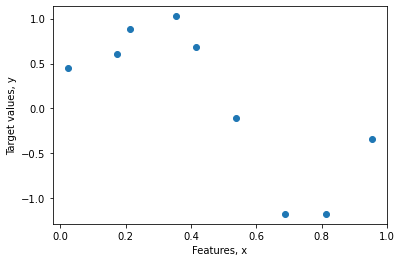

In [3]:
# Plot the data
plt.figure()
plt.scatter(data_regress[:, 0], data_regress[:, 1])
plt.xlabel("Features, x")
plt.ylabel("Target values, y")
plt.show()

**Build the regression tree in the `TreeRegressor` class**.  
***TIP:*** *If you are smart about building the regression tree, you can reuse most of the code for building the classification tree in Question 2.*

In [4]:
class TreeRegressor():
    def __init__(self, data, max_depth=1):
        self.data = data # last element of each row in data is the target variable
        self.max_depth = max_depth # maximum depth
      
        
        #initialize a root node
        self.root = None
        self.min_samples_split = 2 # split when there are at least 2 samples
    
    def generate_tree(self, dataset, depth_now=0):
        """
        Generates a tree recursively.
        
        Args:
            dataset: array contains target value(Y) and feature value(X) 
        Returns:
            tree: model we build
        """
       
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # we try to split "tree" until certain criteria is met
        if num_samples>=self.min_samples_split and depth_now<=self.max_depth:
            # use iterative method to find the optimal split 
            best_split = self.optimal_split(dataset, num_samples, num_features)
            # check whether we reduce the variance by splitting our tree into more branches
            if best_split["var_red"]>0:
                # left branch
                left_subtree = self.generate_tree(best_split["dataset_left"], depth_now+1)
                # right branch
                right_subtree = self.generate_tree(best_split["dataset_right"], depth_now+1)
                
                # return decision node, or say model we build
                self.root = Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
                
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)

        
     
    def optimal_split(self, dataset, num_samples, num_features):
        """
        return optimal split among splits
        """
        
        # we create a dictionary to store the best split
        optimal_split = {}
        max_var_red = -float("inf")
        
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update based on the result we get
                    if curr_var_red>max_var_red:
                        optimal_split["feature_index"] = feature_index
                        optimal_split["threshold"] = threshold
                        optimal_split["dataset_left"] = dataset_left
                        optimal_split["dataset_right"] = dataset_right
                        optimal_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        
        return optimal_split
    
    
    def split(self, dataset, feature_index, threshold):
        """
        return one single split: split data according to the threshold
        """
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        '''compute leaf node '''
        
        leaf_value = np.mean(Y)
        return leaf_value
                
    
    def fit(self, X, Y):
        ''' build the model'''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.generate_tree(dataset)
        
    def dataset_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.dataset_prediction(x, tree.left)
        else:
            return self.dataset_prediction(x, tree.right)
    
    def predict(self, X):
        preditions = [self.dataset_prediction(x, self.root) for x in X]
        return preditions

In [5]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # nodes for making decision (left or right)
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # external node
        self.value = value

**Plot the MSE at each depth of your tree**

In [7]:
mse_depths = []
for depth in range(1, 5):
    # Create a regression tree object
    regressor = TreeRegressor(data_regress, depth)
    X_data = data_regress[:,:-1]
    Y_data = data_regress[:,-1].reshape(-1,1)
    # Train the tree
    tree = regressor.generate_tree(data_regress)
    regressor.fit(X_data,Y_data)
    mse = 0.0
    predict_data = regressor.predict(data_regress[:,:-1])
    #for data_point in predict_data:
        #mse += (data_point[-1] - regressor.predict(data_point[:-1]))**2
    for i in range(len(predict_data)):
        mse += (predict_data[i] - Y_data[i][0])**2
    #print(regressor.predict(data_regress[:,:-1]))
    mse_depths.append(mse/len(data_regress))

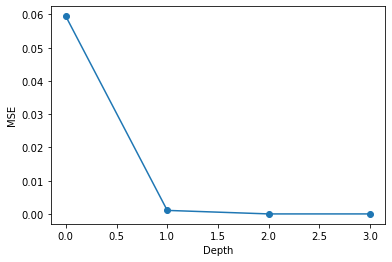

In [8]:
# Plot the MSE
plt.figure()
plt.plot(mse_depths, '-o')
plt.xlabel("Depth")
plt.ylabel("MSE")
plt.show()

## Part 2 

## Growing a two-class classification tree

The figure below shows the growth of a tree to a maximum depth of seven on a two-class classification dataset. As the tree grows, note how many parts of the input space do not change as leaves on the deeper branches become *pure*. By the time we reach a maximum depth of seven, there is considerable overfitting. 

![Error loading image](http://people.tamu.edu/~sumedhpendurkar/csce633/decision_tree_img_2.jpeg)

**Perform the experiment shown in figure by coding up a recursively defined two-class classification tree. Instead of reproducing the plot, measure and plot the classification accuracy at each depth of your tree.**

In [9]:
csvname = 'http://people.tamu.edu/~sumedhpendurkar/csce633/new_circle_data.csv'
data_class = np.loadtxt(csvname, delimiter = ',')
data_class = np.array([[x1, x2, y] for x1,x2,y in zip(*data_class)])

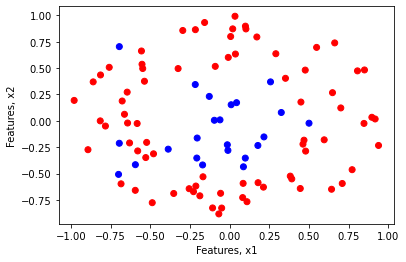

In [10]:
# Plot the data
plt.figure()
plt.scatter(data_class[:, 0], data_class[:, 1], c=-data_class[:, 2], cmap='bwr')
plt.xlabel("Features, x1")
plt.ylabel("Features, x2")
plt.show()

In [11]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        
        # nodes for making decision (left or right)
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for external node
        self.value = value

In [12]:
class TreeClassifier():
    def __init__(self, data, max_depth=1):
        self.data = data # last element of each row in data is the target variable
        self.max_depth = max_depth # maximum depth
        
        self.root = None
        self.min_samples_split = 2 # at least split 2
    
    def generate_tree(self, dataset, depth_now=0):
        """
        Generates a tree recursively.
        """

        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # use iterative method to find the optimal split 
        if num_samples>=self.min_samples_split and depth_now<=self.max_depth:
            # find the optimal split
            best_split = self.optimal_split(dataset, num_samples, num_features)
            # check if IG entropy is positive
            if best_split["info_gain"]>0:
                # left tree
                left_subtree = self.generate_tree(best_split["dataset_left"], depth_now+1)
                # right tree
                right_subtree = self.generate_tree(best_split["dataset_right"], depth_now+1)
                
                
                #self.root = Node(best_split["feature_index"], best_split["threshold"], 
                #            left_subtree, right_subtree, best_split["info_gain"])
                
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    
        
     
                        
    def optimal_split(self, dataset, num_samples, num_features):
        ''' get optimal split '''
        
        # dictionary to store the best split
        optimal_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        optimal_split["feature_index"] = feature_index
                        optimal_split["threshold"] = threshold
                        optimal_split["dataset_left"] = dataset_left
                        optimal_split["dataset_right"] = dataset_right
                        optimal_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        
        return optimal_split
    
    
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def information_gain(self, parent, l_child, r_child):
        ''' function to compute information gain '''

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
       
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def calculate_leaf_value(self, Y):
        
        Y = list(Y)
        return max(Y, key=Y.count)
                
   
    def fit(self, X, Y):
        ''' build the tree model'''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.generate_tree(dataset)
        
    def dataset_prediction(self, x, tree):
        ''' predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.dataset_prediction(x, tree.left)
        else:
            return self.dataset_prediction(x, tree.right)
    
    def predict(self, X):
        ''' predict a single data point '''
        
        preditions = [self.dataset_prediction(x, self.root) for x in X]
        return preditions

In [15]:
mse_depths = []
for depth in range(1, 5):
    # Create a regression tree object
    regressor = TreeRegressor(data_regress, depth)
    X_data = data_regress[:,:-1]
    Y_data = data_regress[:,-1].reshape(-1,1)
    # Train the tree
    tree = regressor.generate_tree(data_regress)
    regressor.fit(X_data,Y_data)
    mse = 0.0
    predict_data = regressor.predict(X_data)
    #for data_point in predict_data:
        #mse += (data_point[-1] - regressor.predict(data_point[:-1]))**2
    for i in range(len(predict_data)):
        mse += (predict_data[i] - Y_data[i][0])**2
    #print(regressor.predict(data_regress[:,:-1]))
    mse_depths.append(mse/len(data_regress))

**Plot the classification accuracy at each depth of your tree.**

In [16]:
accuracy_depths = []
for depth in range(1, 8):
    # Create a classification tree object
    classifier = TreeClassifier(data_class, depth)
    X_data = data_class[:,:-1]
    Y_data = data_class[:,-1].reshape(-1,1)
    # Train the tree
    tree = classifier.generate_tree(data_class)
    classifier.fit(X_data,Y_data)
    caccuracy = 0.0
    #for data_point in data_class:
    #     correct += float(data_point[-1] == predict(tree, data_point[:-1]))
    predict_value = classifier.predict(X_data)
    accuracy = (predict_value == Y_data).mean()
    #accuracy_depths.append(correct/len(data_class))
    accuracy_depths.append(accuracy)

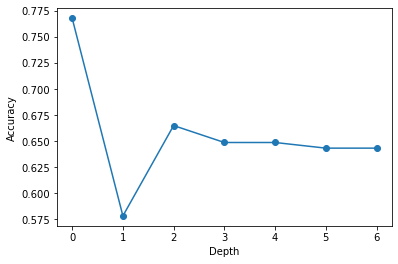

In [17]:
# Plot the Accuracy
plt.figure()
plt.plot(accuracy_depths, '-o')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()